In [60]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sista
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])
exp.load_behavior(0)
print(exp.nsub)

22


In [69]:
from pathlib import Path

k_files = sorted(list(Path(data_dir).glob('*k.csv')))
subix = [str(x.name)[4:6] for x in exp.xdata_files] 
subix_k = [str(k.name)[4:6] for k in k_files]
subMatch=[subix.index(str(sub)) for sub in subix_k]

exp.xdata_files = sorted([exp.xdata_files[i] for i in subMatch])
exp.ydata_files = sorted([exp.ydata_files[i] for i in subMatch])
exp.info_files =  sorted([exp.info_files[i] for i in subMatch])
exp.behavior_files =  sorted([exp.behavior_files[i] for i in subMatch])
exp.artifact_idx_files =  sorted([exp.artifact_idx_files[i] for i in subMatch])
exp.nsub = len(exp.xdata_files)
print(exp.nsub)

18


In [70]:
# function to calculate k

def get_sub_k(filename):
    beh=pd.read_csv(filename).to_dict('list')
    resp=np.array(beh["key_press"])[pd.notna(beh["key_press"])]
    chg=np.array(beh["change"])[pd.notna(beh["change"])]
    hit=np.logical_and(resp=='n',chg==1)
    fa=np.logical_and(resp=='n',chg==0)

    k = 6 * (sum(hit)/sum(chg) - sum(fa)/sum(chg==0))
    return k

In [71]:
time_window = 50
time_step = 50
trial_bin_size = 15
n_splits = 30
group_dict = OrderedDict([('1',[11]),('Set size 2',[20])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [72]:
beh_acc = []
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.group_labels(xdata,ydata)
    beh_acc.append(exp.load_behavior(isub)['ACC'].mean())

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

        X_train_all, y_train = wrangl.balance_labels(X_train_all, y_train)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [90]:
beh_acc = []
for isub in range(exp.nsub):
    beh_acc.append(pd.DataFrame(exp.load_behavior(isub)).query('BlockCondition=="2"')['ACC'].mean())

In [91]:
interp = eeg_decoder.Interpreter(clfr)
# interp.save_results()

In [92]:
k = []
for s in k_files:
    k.append(get_sub_k(s))

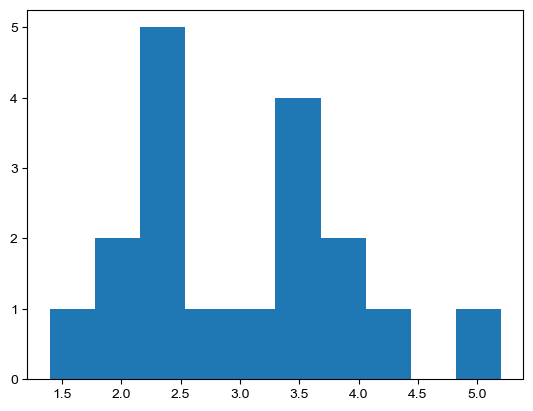

In [93]:
plt.hist(k)
plt.show()

In [94]:
accs = np.mean(np.mean(interp.acc[:,wrangl.t>0],2),1)

In [95]:
def regression_line(slope: float, intercept: float):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='k',zorder=-1)

def plot_corr(x: list, y: list, plot_title = None, x_variable_name = 'X Variable', y_variable_name = 'Y Variable', stats_text = True, stat_xy=(0,0)):
    """Plot correlation between two variables of equal length"""

    # Use scipy.stats.linregress to calc correlation
    slope, intercept, r_value, p_value, std_err = sista.linregress(x, y)
    stats = {'slope':slope, 'intercept':intercept, 'r_value':r_value, 'p_value':p_value, 'std_err':std_err}
    
    # Plotting variables
    ax = plt.subplot(111)
    ax.scatter(x,y,edgecolor='k',color='dodgerblue')

    # Plotting regression line
    regression_line(slope,intercept)

    # Plot labelling
    r_value_round = round(r_value**2,2)
    p_value_round = round(p_value,4)
    if stats_text:
        stats_string = f'$r^2$ = {r_value_round}\np = {p_value_round}'
        plt.text(stat_xy[0],stat_xy[1],stats_string,fontsize=12,bbox=dict(facecolor='none', edgecolor='lightgrey', boxstyle='round'))

    if plot_title:
        full_title = (plot_title)
        plt.title(full_title,fontsize=18)
    
    plt.xlabel(x_variable_name, fontsize=14)
    plt.ylabel(y_variable_name, fontsize=14)

    # Various plot beautification
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)

    
    return stats

In [105]:
mean_acc = np.mean(np.mean(interp.acc[:,interp.t>200],2),1)

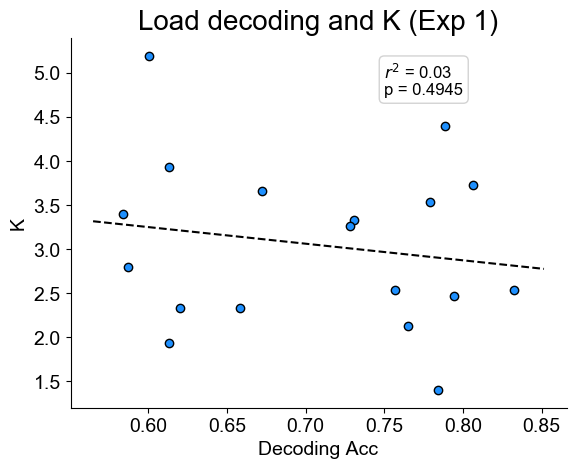

In [113]:
plot_corr(mean_acc,k,stat_xy=(.75,4.75),x_variable_name='Decoding Acc',y_variable_name='K')
plt.title('Load decoding and K (Exp 1)',fontsize=20)
plt.show()

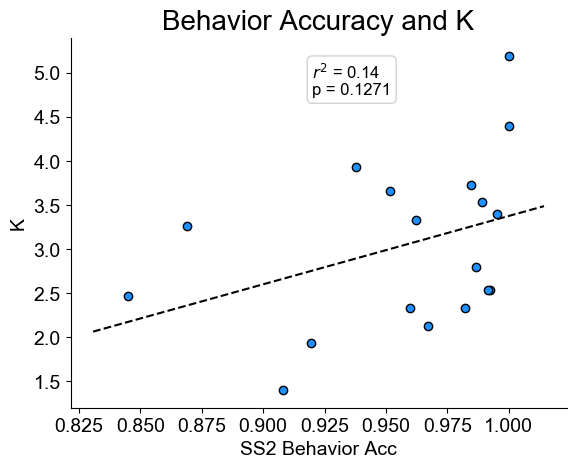

In [111]:
plot_corr(beh_acc,k,stat_xy=(.92,4.75),x_variable_name='SS2 Behavior Acc',y_variable_name='K')
plt.title('Behavior Accuracy and K',fontsize=20)
plt.show()

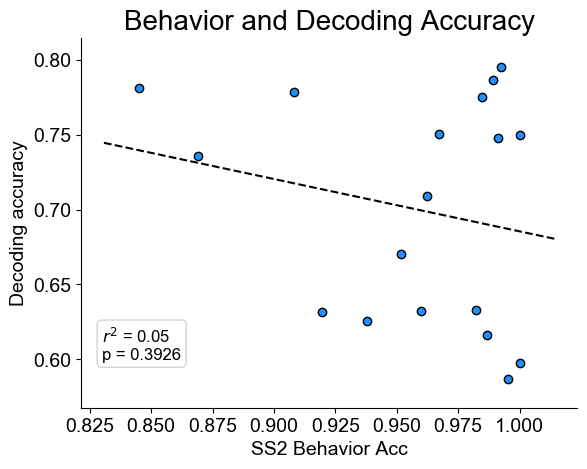

In [112]:
plot_corr(beh_acc,accs,stat_xy=(.83,.6),x_variable_name='SS2 Behavior Acc',y_variable_name='Decoding accuracy')
plt.title('Behavior and Decoding Accuracy', fontsize=20)
plt.show()

No handles with labels found to put in legend.


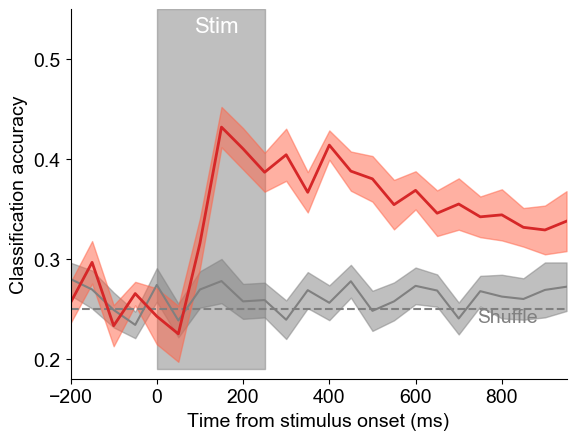

Mean delay accuracy: 0.36145174444046624
Mean delay S.D.: 0.025681581468865566


In [18]:
interp.plot_acc()